## Preparation

##### Import Functions

In [3]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from skimage import io
from matplotlib import pyplot as plt
from skimage.draw import circle, circle_perimeter
from skimage.color import rgb2hsv, rgb2hed, hed2rgb, rgb2gray
from Scripts.LoadImage import LoadImage as LoadImage
from Scripts.Fuzzify import Fuzzify as Fuzzify
from Class.Helper import Helper as Helper
from Scripts.Ki67 import Ki67 as Ki67

##### Functions

In [4]:
def getRecall(markers, mask):
    radius = 3
    hits = markers.apply(lambda marker: mask[int(marker['y'])-radius:int(marker['y']) + radius + 1, int(marker['x'])-radius:int(marker['x']) + radius + 1].any(),axis=1)
    recall = hits.sum() / len(hits)
    return recall

def validateResults(folder_name, low_x, high_x, low_y, high_y, show_images = False):
    path = settings.data_folder_veryfication
    mask = pickle.load(open(settings.backup_folder + "Images/" + "Test_" + folder_name + "_" + settings.class_1 + "_df_results"  + ".p", "rb"))
    mask = mask.sort_index()
    
    if settings.class_1 == "brown":
        searched_class = 1
    else:
        searched_class = 2
    
    mask = np.reshape(np.array(mask["Decision Fuzzy"]), (-1, high_x - low_x))
    
    mask = [np.ones(3) if j == settings.class_1 else np.zeros(3) for row in mask for j in row]
    mask = np.array(mask)
    mask = mask.reshape((-1, high_x - low_x, 3))

    from skimage.morphology import binary_closing
    from skimage.morphology import disk, remove_small_objects
    from skimage.color import rgb2gray
    from skimage import data, io, segmentation, color

    file_path = path + folder_name
    image_raw= io.imread(file_path + "/fragment.png")
    base = io.imread(file_path + "/base.png")
    markers = pd.read_csv(file_path + "/markers.csv")

    k = 3
    markers.loc[:, 'x'] = markers.x.apply(lambda x: np.ceil(x / k))
    markers.loc[:, 'y'] = markers.y.apply(lambda y: np.ceil(y / k))
    markers = markers.drop(markers[((markers.x < low_x) | (markers.x > high_x)) | ((markers.y < low_y) | (markers.y > high_y))].index)
    markers.loc[:, 'x'] = markers.x.apply(lambda x: x - low_x)
    markers.loc[:, 'y'] = markers.y.apply(lambda y: y - low_y)

    markers = markers.loc[markers.type == searched_class]

    if show_images:
        fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(70, 45))
    mask_gray = rgb2gray(mask)
    if show_images:
        ax[0].imshow(mask, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(1))
    if show_images:
        ax[1].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = remove_small_objects(mask_gray, 3)
    if show_images:
        ax[2].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(2))
    if show_images:
        ax[3].imshow(mask_gray, cmap=plt.cm.gray)

    mask_gray = mask_gray.astype(bool)
    recall = getRecall(markers, mask_gray)
    
    if show_images:
        for center_y, center_x in zip(markers.y, markers.x):
            circy, circx = circle_perimeter(int(center_y), int(center_x), 0)
            image_raw[circy, circx] = (220, 20, 20)
        
        ax[4].imshow(image_raw, cmap=plt.cm.gray)
        plt.show()
        
    return recall

### Analysis - Input Membership Functions

In [ ]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings

for gauss in [3, 5, 7, 9, 11]:
    for style in ["Gaussian Progressive", "Gaussian Equal"]:
        for adjustment in [-1, -2]:
            for cell_type in ["brown", "blue"]:
                generalSettings.gausses = gauss
                generalSettings.style = style
                generalSettings.adjustment_value = adjustment
                generalSettings.class_1 = cell_type
                settings = Settings(generalSettings)        

                # Generate Rules
                loadImage = LoadImage()
                samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

                fuzzify = Fuzzify()
                changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

                # Validate Results
                for file_name in ["1628-05", "18583-04", "31374-10",]:
                    generalSettings.file_name = file_name
                    settings = Settings(generalSettings)     
                    loadImage = LoadImage()
                    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = -1)

                    ki67Test = Ki67(settings, settings.s_function_width, False)
                    ki67Test.noOptymalizationWorker(settings)

                    if file_name == "1628-05":
                        recall_1 = validateResults(settings.file_name, 85, 449, 172, 533, False)
                    elif file_name == "18583-04":
                        recall_2 = validateResults(settings.file_name, 1732, 2011, 583, 995, False)
                    else:
                        recall_3 = validateResults(settings.file_name, 432, 794, 300, 566, False)
                avg_recall = (recall_1 + recall_2 + recall_3) / 3
                helper = Helper()

                fuzzification_data = ["Ki67", settings.style, settings.gausses, settings.adjustment, settings.class_1, settings.features_type, samples_stats, train_stats, test_stats, changed_decisions, round(changed_decisions / train_samples, 2), implicants_number, settings.feature_numbers, features_number_after_reduct, recall_1, recall_2, recall_3, avg_recall, execution_time]
                helper.saveFuzzificationStatsKi67(fuzzification_data)

In [8]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings
generalSettings.file_name = "503-05"

from skimage.transform import rescale
settings = Settings(generalSettings)    

name = "base.png"
image = io.imread(settings.data_folder_test + settings.file_name + "/base.png")
mask = io.imread(settings.data_folder_test + settings.file_name + "/mask-gt.png")
image_rescaled = rescale(image, 1.0 / 3.0, anti_aliasing=False)
mask_rescaled = rescale(mask, 1.0 / 3.0, anti_aliasing=False)
print("File: {}".format(file_path))
print("Width: {}\t Height: {}".format(image.shape[0], image.shape[1]))
print("Width: {}\t Height: {}".format(image_rescaled.shape[0], image_rescaled.shape[1]))
print("Width: {}\t Height: {}".format(mask.shape[0], mask.shape[1]))
print("Width: {}\t Height: {}".format(mask_rescaled.shape[0], mask_rescaled.shape[1]))

C:\Programy\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Programy\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


File: ../Data/Ki67-Test/503-05/base.png
Width: 1584	 Height: 1616
Width: 528	 Height: 539
Width: 1584	 Height: 1616
Width: 528	 Height: 539


### Result Validation

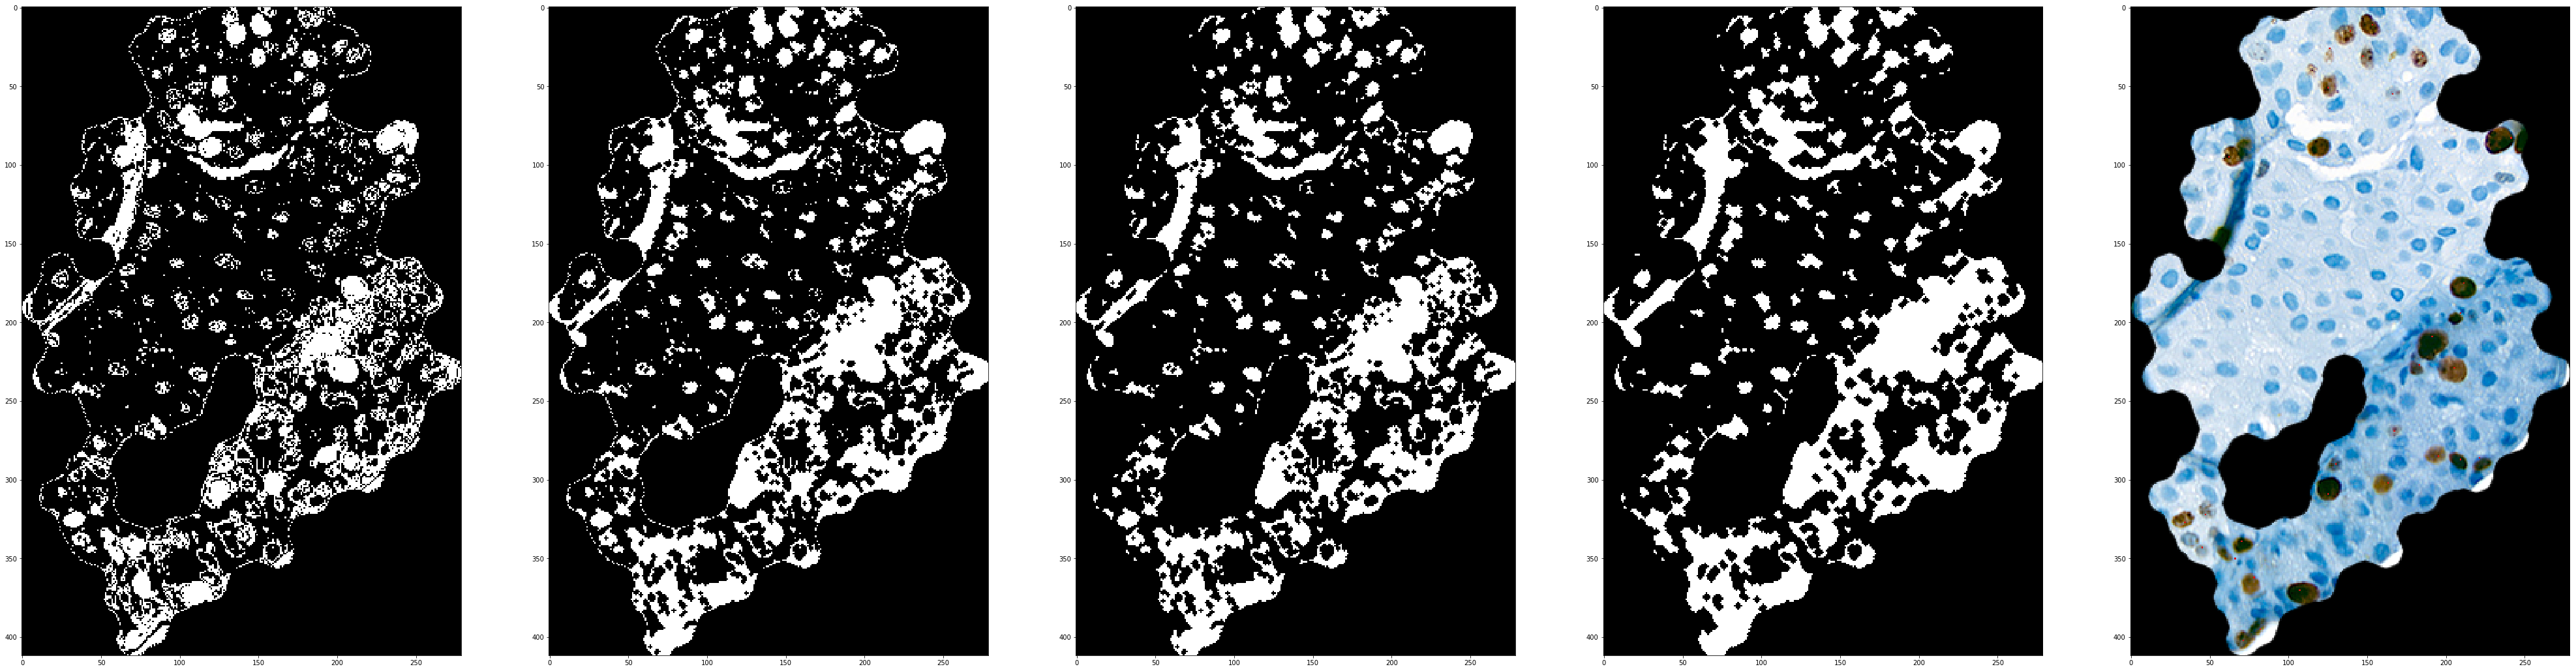

1.0

In [12]:
validateResults("18583-04", 1732, 2011, 583, 995, True)